In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi, isnan, isinf
from scipy.optimize import minimize
from scipy.linalg import inv
from scipy import stats

# GARCH-MIDAS

Key points:
- Model uses mean-reverting unit daily GARCH process to fit the short-lived component (fast) of the volatility; MIDAS polynomial to depict the secular component driven by some lower frequency variables (slow)


$$r_{i,t} = \mu + \sqrt{\tau_ig_{i,t}}\epsilon_{i,t}, \forall i = 1, 2, ..., N_t$$

whereby
- $r_{i,t}$: price return (log or compound return?)
- $\mu$: mean daily return conditional on information set $\Psi_{i-1}$ 
- $N_t$: number of days in month t
- $g_{i,t}$: short-term component of the conditional probability
- $\tau_t$: secular component


Garch(1,1) process:
$$g_{i,t} = (1 - \alpha - \beta) + \alpha \frac{(r_{i-1,t}-\mu)^2}{\tau_t} + \beta g_{i-1,t}$$


MIDAS regression (which one? hmmm....):
$$\tau_t = m^2 + \underbrace{\theta_R^2 \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

$$log(\tau_t) = m + \underbrace{\theta_R \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

where:
- $RV_t$: realized volatility of daily returns in month $t$
- $K_r$: number of periods over which the realized volatility is smoothed
- $\theta$: measures the contribution of RV to the secular component


Original Study:
- In-sample estimation: January 1, 1991 - December 31, 2021
- Out-sample test: January 1, 2022 - July 29, 2022
- Forecasts in this study were conducted with a rolling-window approach—i.e., using data from January 1, 1991, to December 31,
2021, to project the price volatility on January 1, 2022; using data from January 2, 1991, to January 1, 2022, to project the volatility
on January 2, 2022; and so on.

Further reference:
https://github.com/blake-marsh/GARCH_replication


In [106]:
# params : [mu, theta, omega_2, alpha, beta, m]
def beta_lag_wt_scheme(K, omega_2, omega_1 = 1):
    '''
    Function to generate an array of factor weights phis
    Args:
        K (int) : the number of lags.
        omega_1 (float, optional) : The first parameter of the weighting scheme. Defaults to 1.
        omega_2 (float) : The second parameter of the weighting scheme.

    Returns:
        ndarray: A column vector representing the weighting scheme.

    '''
    j_vec = np.arange(K,0,-1)
    denom =\
    (
        np
        .sum(
            (j_vec/(K+1)) ** (omega_1 - 1.0)
            * (1.0 - j_vec/(K+1)) ** (omega_2 - 1.0)
        )
    )

    numer =\
    (
        (j_vec/(K+1)) ** (omega_1 - 1.0)
        * (1.0 - j_vec/(K+1)) ** (omega_2 - 1.0)
    )

    return (numer / denom).reshape(j_vec.shape[0],1)
    
def get_onefactor_tau(params, X, K):
    '''
    Function to return an array of taus based on one-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 6 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta, omega, m = params
    
    tau = m**2 + theta**2 * np.dot(X, beta_lag_wt_scheme(K, omega))
    T = tau.size

    return mu, alpha, beta, tau, T

def get_twofactor_tau(params, X, K):
    '''
    Function to return an array of taus based on two-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 8 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta1, theta2, omega1, omega2, m = params
    X1, X2 = X
    #log_tau = m**2 + theta**2 * np.dot(X, beta_lag_wt_scheme(K, omega))
    tau =\
    (
        m**2 
        + theta1**2 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
        + theta2**2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
    )
    T = tau.size

    return mu, alpha, beta, tau, T

def get_threefactor_tau(params, X, K):
    '''
    Function to return an array of taus based on three-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 10 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta1, theta2,theta3, omega1, omega2, omega3, m = params
    X1, X2, X3 = X
    #log_tau = m**2 + theta**2 * np.dot(X, beta_lag_wt_scheme(K, omega))
    tau =\
    (
        m**2 
        + theta1**2 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
        + theta2**2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
        + theta3**2 * np.dot(X3, beta_lag_wt_scheme(K, omega3))
    )
    T = tau.size

    return mu, alpha, beta, tau, T


def GARCH_MIDAS(params, returns, X, K, get_tau = get_onefactor_tau, full_output = False):
    '''
    Function representing the GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the parameters required for the model
        X (ndarray or tuple) : A set of matrices of the factor values. If there are more than one factor, a tuple is used.
        K (int) : The number of lags.
        get_tau (obj, optional) : The function required to get the required tau array. Defaults to one factor model, get_onefactor_tau
        full_output (bool, optional) : If True, it returns a set of outputs -loglik, logliks, e, tau, gt, ht, T. Otherwise, returns loglik. Defaults to False.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''

    mu, alpha, beta, tau, T = get_tau(params, X, K)
    
    ## define the squared errors
    e = returns[-tau.shape[0]:] - mu
    e2 = e**2
    e2 = e2.flatten()
    

    # define g
    gt = np.array([tau[0]])

    for t in range(1, tau.size):
        
        gt =\
            np.append(gt, 
                      (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
    
    gt = gt.reshape(-1,1)
    ht = np.multiply(tau,gt).flatten()

    # log likelihood
    logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))
    
    if isnan(logliks.sum()) or isinf(logliks.sum()):
        loglik = 1E10
    else:
        loglik = logliks.sum()

    
    if full_output == True:
        return -loglik, logliks, e, tau, gt, ht, T

    else:
        return loglik



In [109]:
#hessian_matrix is used to calculate the variance matrix
#fun = Garch_midas and theta = params
#variance is where we obtain standard error,se
#param / se is t-stats
#pvalue



def hessian_matrix(fun, theta, args, epsilon=1e-05):
    '''
    Function to calculate the hessian matrix of the model.

    '''
    f = fun(theta, *args) #initilised garch-midas fn (obj fn) and returns loglik
    h_ = epsilon*np.abs(theta) #small change in each parameter, scaled. 
    
    h = np.diag(h_) #aligning the small changes into a diagonal matrix
    K = theta.shape[0] #length of params
    
    fp = np.zeros(K) #initialise +forward change to obj fn
    fm = np.zeros(K) #initialise -backward change to obj fn
    for i in range(K):
        fp[i] = fun(theta+h[i], *args) #objective fn with params, plus small forward change
        fm[i] = fun(theta-h[i], *args) #objective fn with params, minus small forward change
        
    fpp = np.zeros((K,K))
    fmm = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            fpp[i,j] = fun(theta + h[i] + h[j],  *args) #objective fn with params, plus 2x small forward change
            fpp[j,i] = fpp[i,j] #symmetry
            fmm[i,j] = fun(theta - h[i] - h[j],  *args) #objective fn with params, minus 2x small forward change
            fmm[j,i] = fmm[i,j]
            
    hh = (np.diag(h))
    hh = hh.reshape((K,1))
    hh = np.dot(hh,hh.T) #h^2, scalar, sum of small changes^2a  
    
    H = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            H[i,j] = (fpp[i,j] - fp[i] - fp[j] + f 
                       + f - fm[i] - fm[j] + fmm[i,j])/hh[i,j]/2
            H[j,i] = H[i,j]
    
    return H

def summary_stats(fun, T, params, args, labels, epsilon=1e-05):
    '''
    Function to calculate the p-values of the parameters given the model.

    '''
    H = hessian_matrix(fun, params, args, epsilon = epsilon)
    vcv = inv(H/T)/T #variance vector / sample_size^2
    #print(vcv)
    se = np.diag(vcv)**0.5 #standard error
    t = params/se
    pvalues = stats.t.sf(np.abs(t),args[0].size - params.shape[0])

    df =\
    (
        pd
        .DataFrame(
            data = {'values': params, 
                    'p-val': pvalues}, 
            index = labels
            ).T
    )

    return df


In [110]:
# summary_stats(GARCH_MIDAS, 
#               T, 
#               results['x'], 
#               (returns_test, X1_test, 36), 
#               ['mu', 'alpha', 'beta', 'theta', 'omega', 'm'])

---

# Data Processing
- Read csvs containing CPU, EMDAT, Futures data

In [111]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('natgas_futures_price.csv', sep=',')

In [112]:
# Combine Dataframe

# Prepare CPU index data
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

# Process EM-DAT data
emdat = emdat[['Country', 'Subregion', 'Region', 
               'Disaster Group', 'Disaster Subgroup', 
               'Disaster Type','Start Year', 'Start Month', 
               'End Year', 'End Month']]
emdat.dropna(inplace=True)

# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] =\
    pd\
    .to_datetime(
        emdat['Start Year'].astype(str) 
        + '-' 
        + emdat['Start Month'].astype(int).astype(str).str.zfill(2))

# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)

# Futures prices
natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%d/%m/%y')
natgas_futures.set_index('Date', inplace=True)
# Log returns rescaled to 100
natgas_futures['daily_return'] =\
np.log(
    natgas_futures['natgas_future_price']/
    natgas_futures['natgas_future_price'].shift()
) * 100

# Consolidating the three data series into single dataframe 
natgas_futures['YYYY-MM'] = natgas_futures.index.to_period('M')
cpu['YYYY-MM'] = cpu.index.to_period('M')
emdat_mthly_freq['YYYY-MM'] = emdat_mthly_freq.index.to_period('M')

data =\
    natgas_futures\
        .merge(
            cpu,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            emdat_mthly_freq,
            how = 'left',
            on = 'YYYY-MM'
        )

data.index = natgas_futures.index
data.dropna(inplace = True)
data.head()

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
1994-01-14,2.268,3.317202,1994-01,56.733087,22
1994-01-17,2.360,3.976323,1994-01,56.733087,22
1994-01-18,2.318,-1.795687,1994-01,56.733087,22
1994-01-19,2.252,-2.888603,1994-01,56.733087,22
1994-01-20,2.250,-0.088849,1994-01,56.733087,22


In [113]:
data.tail()

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
2023-12-22,2.610,1.466641,2023-12,240.119738,23
2023-12-26,2.550,-2.325686,2023-12,240.119738,23
2023-12-27,2.619,2.669921,2023-12,240.119738,23
2023-12-28,2.557,-2.395787,2023-12,240.119738,23
2023-12-29,2.514,-1.695959,2023-12,240.119738,23


In [114]:
#endo: daily_return
#in-sample 29 years of data or from Jan 1994 to Dec 2022
#out-sample 1 year + 36 months of lag = 2019 to 2023 data

#exo: daily_return (cpu & disaster freq)

In [115]:
data.index.year

Index([1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994,
       ...
       2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023],
      dtype='int32', name='Date', length=7525)

In [116]:
data_train = data[data.index.year <= 2019]

In [117]:
data_test = data[data.index.year > 2019]

In [118]:
def get_realized_variance(data, target):
        
    factor =\
    (
        data[[target]]
        .resample('M')
        .agg(lambda x: (x ** 2).sum())
        .rename(columns = {target : 'realized_variance'})
    ).iloc[1:]

    return factor


#get factor and its lags
def get_factors(data, target, K, fun = None):
    '''
    Function to derive the factor values required.

    Args:
        data (DataFrame) : The dataframe containing the original data.
        target (string) : The name of the target factor.
        K (int) : The number of lags.
        fun (obj, optional) : The function to use to derive the factor values. Defaults to None


    returns:
        ndarray : The derived matrix of factor values.
    '''
   
    if fun:
        factor = fun(data, target)
        target = 'realized_variance'

    else:
        factor =\
        (
            data[[target]]
            .resample('M')
            .mean()
        ).iloc[1:]

    for i in range(1,K+1):
        factor[f'{target}_lag_{str(i).zfill(2)}'] =\
            factor[f'{target}'].shift(i)

        
    factor.dropna(inplace = True)
    factor['YYYY-MM'] = factor.index.to_period('M')
    
    X =\
    (
        np.array(
            data[['YYYY-MM']]
            .merge(factor,
                how = 'left',
                on = 'YYYY-MM')
            .dropna()
            .iloc[:,:1:-1]
        )
    )

    return X #factor and its lags

---
## One-factor GARCH-MIDAS 

### Model 1: Realized Variance

In [119]:
data_test

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
2020-01-02,2.122,-3.108578,2020-01,209.347085,29
2020-01-03,2.130,0.376294,2020-01,209.347085,29
2020-01-06,2.135,0.234467,2020-01,209.347085,29
2020-01-07,2.162,1.256707,2020-01,209.347085,29
2020-01-08,2.141,-0.976071,2020-01,209.347085,29
...,...,...,...,...,...
2023-12-22,2.610,1.466641,2023-12,240.119738,23
2023-12-26,2.550,-2.325686,2023-12,240.119738,23
2023-12-27,2.619,2.669921,2023-12,240.119738,23


In [120]:
X1_train = get_factors(data_train, 'daily_return', 36, fun = get_realized_variance)
X1_test = get_factors(data_test, 'daily_return', 36, fun = get_realized_variance)

In [121]:
#training the model to optimize coefficients. 
#Using data_train

## initial values - mu, alpha, beta, theta, omega, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 1, -2])

returns_train = np.array(data_train[['daily_return']])
returns_test = np.array(data_test[['daily_return']])

# method='L-BFGS-B', \
results = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (returns_train, X1_train, 36)) ## Limited Memory BFGS

results

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_2079/3370469450.py:50: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


      fun: 14677.785943917028
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02328306,  0.04656613,  0.38635335, -0.20045263,  0.03055902,
        0.00145519])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 434
      nit: 57
     njev: 62
   status: 0
  success: True
        x: array([ 0.02520251,  0.07693221,  0.89793371,  0.20972768, -0.13012655,
       -0.39489616])

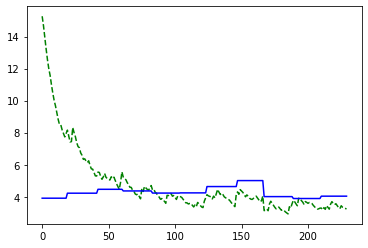

In [122]:
# lag should remain at 36 months but data_train is 4 years long.

loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results['x'], returns_test, X1_test, 36, full_output=True) 

# Plot 
t = np.array([t for t in range(T)])
plt.plot(t, np.sqrt(ht), 'g--', np.sqrt(tau),'b-')
plt.show()

In [123]:
tau

array([[15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [15.26597694],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [17.80548903],
       [19.9126388 ],
       [19.9126388 ],
       [19.9126388 ],
       [19

In [124]:
ht

array([233.05005201, 215.09521232, 193.5451545 , 174.45681695,
       157.31390385, 143.57566662, 133.72420103, 120.60649406,
       109.55569581, 100.28619164,  93.67803413,  85.63282391,
        78.16563651,  72.42948624,  72.10814487,  66.85467788,
        63.38701786,  59.82398704,  63.06170696,  66.51646304,
        60.57408233,  55.05492154,  55.35233787,  69.15581791,
        63.9999118 ,  60.01083329,  54.34213163,  50.85024753,
        49.842238  ,  45.33248527,  43.37458957,  40.08903566,
        40.52560872,  38.81360931,  37.58081628,  38.94883864,
        35.47164148,  32.90726026,  32.74251029,  30.46963401,
        28.10431274,  28.00640961,  30.67373094,  30.40873241,
        27.81801031,  25.87732737,  27.44307854,  29.67597582,
        27.17686041,  26.37448578,  25.55367565,  25.50141454,
        27.51521398,  26.3755848 ,  27.24182518,  25.0694313 ,
        23.05320732,  21.43641139,  19.91284793,  24.09730637,
        30.829524  ,  27.31147209,  26.18237627,  25.62

In [125]:
#green line represents forecast
#blue line represents actual 

#could be because the unexpectedly high volatility in 2020 - 2021? 

In [126]:
vcv = summary_stats(GARCH_MIDAS, 
              T, 
              results['x'], 
              (returns_test, X1_test, 36), 
              ['mu', 'alpha', 'beta', 'theta', 'omega', 'm'])[1]

vcv

[[ 2.51214206e-01  2.70739916e-03 -1.67014653e-03  4.76197046e-03
  -1.61721634e-01 -9.52912166e-02]
 [ 2.70739916e-03  2.55818676e-03 -2.54213198e-03  1.21719648e-03
  -2.66482168e-02  2.27080160e-02]
 [-1.67014653e-03 -2.54213198e-03  3.66852057e-03 -1.54314081e-03
   1.95860370e-02 -1.74995226e-02]
 [ 4.76197046e-03  1.21719648e-03 -1.54314081e-03  2.88545184e-03
  -6.75470013e-02  6.02260310e-02]
 [-1.61721634e-01 -2.66482168e-02  1.95860370e-02 -6.75470013e-02
   1.78774511e+00 -1.55141959e+00]
 [-9.52912166e-02  2.27080160e-02 -1.74995226e-02  6.02260310e-02
  -1.55141959e+00  1.58128044e+00]]


array([[ 2.51214206e-01,  2.70739916e-03, -1.67014653e-03,
         4.76197046e-03, -1.61721634e-01, -9.52912166e-02],
       [ 2.70739916e-03,  2.55818676e-03, -2.54213198e-03,
         1.21719648e-03, -2.66482168e-02,  2.27080160e-02],
       [-1.67014653e-03, -2.54213198e-03,  3.66852057e-03,
        -1.54314081e-03,  1.95860370e-02, -1.74995226e-02],
       [ 4.76197046e-03,  1.21719648e-03, -1.54314081e-03,
         2.88545184e-03, -6.75470013e-02,  6.02260310e-02],
       [-1.61721634e-01, -2.66482168e-02,  1.95860370e-02,
        -6.75470013e-02,  1.78774511e+00, -1.55141959e+00],
       [-9.52912166e-02,  2.27080160e-02, -1.74995226e-02,
         6.02260310e-02, -1.55141959e+00,  1.58128044e+00]])

In [127]:
import scipy
scipy.linalg.det(vcv)

-9.297172743687834e-20

In [128]:
summary_stats(GARCH_MIDAS, 
              T, 
              results['x'], 
              (returns_test, X1_test, 36), 
              ['mu', 'alpha', 'beta', 'theta', 'omega', 'm'])[0]

[[ 2.51214206e-01  2.70739916e-03 -1.67014653e-03  4.76197046e-03
  -1.61721634e-01 -9.52912166e-02]
 [ 2.70739916e-03  2.55818676e-03 -2.54213198e-03  1.21719648e-03
  -2.66482168e-02  2.27080160e-02]
 [-1.67014653e-03 -2.54213198e-03  3.66852057e-03 -1.54314081e-03
   1.95860370e-02 -1.74995226e-02]
 [ 4.76197046e-03  1.21719648e-03 -1.54314081e-03  2.88545184e-03
  -6.75470013e-02  6.02260310e-02]
 [-1.61721634e-01 -2.66482168e-02  1.95860370e-02 -6.75470013e-02
   1.78774511e+00 -1.55141959e+00]
 [-9.52912166e-02  2.27080160e-02 -1.74995226e-02  6.02260310e-02
  -1.55141959e+00  1.58128044e+00]]


,mu,alpha,beta,theta,omega,m
values,0.025203,0.076932,8.979337e-01,0.209728,-0.130127,-0.394896
p-val,0.479953,0.064283,2.195765e-45,0.000050,0.461245,0.376780


---
## Two-factors GARCH-MIDAS

In [42]:
#question for caden: why didn't we use realized variance= return**2? note we are using .mean()

X2_train = get_factors(data_train, 'cpu_index', 36)
X2_test = get_factors(data_test, 'cpu_index', 36)
X3_train = get_factors(data_train, 'Monthly_Disaster_Freq', 36)
X3_test = get_factors(data_test, 'Monthly_Disaster_Freq', 36)

Model 2: RV + CPU

In [38]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 1, 1, -2])

# method='L-BFGS-B', \
results2 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (returns_train, (X1_train, X2_train), 36, get_twofactor_tau)) ## Limited Memory BFGS

results2

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_2079/3370469450.py:50: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


      fun: 14677.785933284269
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02273737, -0.07585186, -0.10968506,  0.15588739, -0.02637535,
       -0.00163709,  0.        , -0.0005457 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 585
      nit: 56
     njev: 65
   status: 0
  success: True
        x: array([ 2.51437905e-02,  7.69585606e-02,  8.97903898e-01,  2.09749296e-01,
       -1.05514699e-04, -1.30579442e-01,  9.96984232e-01, -3.96124457e-01])

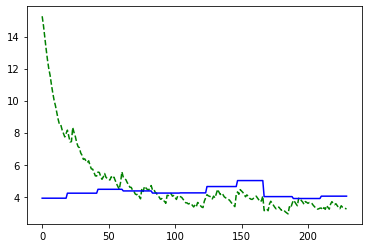

In [39]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results2['x'], returns_test, (X1_test, X2_test), 36, get_tau=get_twofactor_tau, full_output=True)

# Plot 
t = np.array([t for t in range(T)])
plt.plot(t, np.sqrt(ht), 'g--', np.sqrt(tau),'b-')
plt.show()

In [40]:
summary_stats(GARCH_MIDAS, 
              T, 
              results2['x'], 
              (returns_test, (X1_test, X2_test), 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_2079/3689699364.py:52: RuntimeWarning: invalid value encountered in sqrt
  se = np.diag(vcv)**0.5 #standard error


,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.025144,0.076959,0.897904,0.209749,-0.000106,-0.130579,0.996984,-0.396124
p-val,0.458677,NaN,0.000000,NaN,0.339391,0.415442,NaN,0.300723


Model 3: RV + EMDAT

In [43]:
# method='L-BFGS-B', \
results3 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (returns_train, (X1_train, X3_train), 36, get_twofactor_tau)) ## Limited Memory BFGS

results3

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_2079/3370469450.py:50: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


      fun: 14669.379733195627
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.53522706e-01, -9.42600309e-01, -4.65661285e-01, -3.73074727e-01,
       -9.85892257e-02, -1.92812877e-02,  1.81899055e-04,  1.09139364e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1251
      nit: 116
     njev: 139
   status: 0
  success: True
        x: array([ 2.81071548e-02,  7.43387798e-02,  9.01561137e-01,  1.80018886e-01,
       -3.38022684e-01, -3.03670701e-01,  1.16805639e+02,  4.03513603e-04])

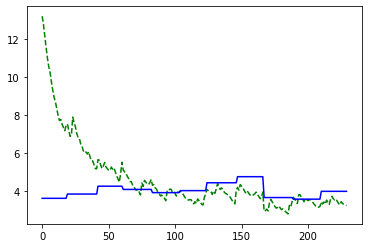

In [45]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results3['x'], returns_test, (X1_test, X3_test), 36, get_tau=get_twofactor_tau, full_output=True)

# Plot 
t = np.array([t for t in range(T)])
plt.plot(t, np.sqrt(ht), 'g--', np.sqrt(tau),'b-')
plt.show()

In [46]:
summary_stats(GARCH_MIDAS, 
              T, 
              results3['x'], 
              (returns_test, (X1_test, X3_test), 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_2079/3689699364.py:52: RuntimeWarning: invalid value encountered in sqrt
  se = np.diag(vcv)**0.5 #standard error


,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.028107,0.074339,0.901561,0.180019,-0.338023,-0.303671,116.805639,0.000404
p-val,0.458583,NaN,NaN,NaN,0.006587,0.320563,NaN,0.490464


---
## Three-Factors GARCH-MIDAS
Model 4: RV + CPU + EMDAT, K = 36

In [47]:
## initial values - mu, alpha, beta, theta1, theta2, theta3, omega1, omega2, omega3, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results4 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (returns_train, (X1_train, X2_train, X3_train), 
                          36, get_threefactor_tau)) ## Limited Memory BFGS

results4

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_2079/3370469450.py:50: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


      fun: 14669.379748608337
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.60381988e-02, -2.28646968e+00, -1.25783117e+00,  1.37843017e+00,
        4.25643520e-02, -8.18545232e-03,  6.36646292e-03,  0.00000000e+00,
       -1.81899055e-04, -9.27684596e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1760
      nit: 139
     njev: 160
   status: 0
  success: True
        x: array([ 2.80090198e-02,  7.43571042e-02,  9.01539801e-01,  1.80269694e-01,
        7.86572152e-05, -3.37063595e-01, -3.02232969e-01,  9.39050370e-01,
        1.17981227e+02, -3.65060295e-03])

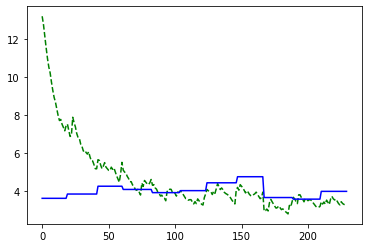

In [48]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results4['x'], returns_test, (X1_test, X2_test, X3_test), 36, get_tau=get_threefactor_tau, full_output=True)

# Plot 
t = np.array([t for t in range(T)])
plt.plot(t, np.sqrt(ht), 'g--', np.sqrt(tau),'b-')
plt.show()

In [50]:
summary_stats(GARCH_MIDAS, 
              T, 
              results4['x'], 
              (returns_test, (X1_test, X2_test,  X3_test), 36, get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_2079/3689699364.py:52: RuntimeWarning: invalid value encountered in sqrt
  se = np.diag(vcv)**0.5 #standard error


,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.028009,0.074357,0.90154,0.18027,0.000079,-0.337064,-0.302233,0.939050,117.981227,-0.003651
p-val,0.460850,NaN,NaN,NaN,NaN,0.006749,0.320818,0.486587,NaN,0.479733


Model 5: RV + CPU + EMDAT, K = 33

In [51]:
#question for caden: why didn't we use realized variance= return**2? note we are using .mean()

X1_3fac_train = get_factors(data_train, 'daily_return', 33, fun = get_realized_variance)
X2_3fac_train = get_factors(data_train, 'cpu_index', 33)
X3_3fac_train = get_factors(data_train, 'Monthly_Disaster_Freq', 33)

X1_3fac_test = get_factors(data_test, 'daily_return', 33, fun = get_realized_variance)
X2_3fac_test = get_factors(data_test, 'cpu_index', 33)
X3_3fac_test = get_factors(data_test, 'Monthly_Disaster_Freq', 33)

In [52]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results5 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (returns_train, (X1_3fac_train, X2_3fac_train, X3_3fac_train), 
                          33, get_threefactor_tau)) ## Limited Memory BFGS

results5

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_2079/3370469450.py:50: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


      fun: 14896.630317419076
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.21961124e-02, -3.64707376e-01, -5.58247845e-01, -1.25510269e-01,
       -2.72848411e-02,  1.96087057e-01,  6.34827302e-02,  1.81898939e-04,
        7.27595701e-04,  2.74667400e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2079
      nit: 157
     njev: 189
   status: 0
  success: True
        x: array([ 2.25503983e-02,  7.77575462e-02,  9.04353383e-01,  1.15234170e-01,
       -6.40279735e-05,  5.74318972e-01, -1.42945030e-01,  9.95103271e-01,
        1.40825300e+01,  1.68408902e-02])

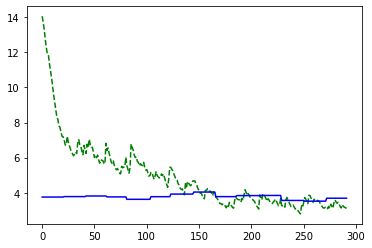

In [53]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results5['x'], 
                                                  returns_test, 
                                                  (X1_3fac_test, X2_3fac_test, X3_3fac_test), 
                                                  33, 
                                                  get_tau=get_threefactor_tau, 
                                                  full_output=True)

# Plot 
t = np.array([t for t in range(T)])
plt.plot(t, np.sqrt(ht), 'g--', np.sqrt(tau),'b-')
plt.show()

In [54]:
summary_stats(GARCH_MIDAS, 
              T, 
              results4['x'], 
              (returns_test, (X1_3fac_test, X2_3fac_test,  X3_3fac_test), 
              33, 
              get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_2079/3689699364.py:52: RuntimeWarning: invalid value encountered in sqrt
  se = np.diag(vcv)**0.5 #standard error


,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.028009,0.074357,0.90154,0.18027,0.000079,-0.337064,-0.302233,0.93905,117.981227,-0.003651
p-val,0.252589,NaN,NaN,NaN,0.499413,0.006707,0.281677,NaN,0.146169,NaN


---